In [180]:
## This notebook will be used to draw distributions and scatterplots for each of the GI / eGI / dGI maps with 
## thresholding for the gene-ntc distributions

In [2]:
## Import modules

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats
from scipy.stats import gaussian_kde
import seaborn as sns
import joypy

In [3]:
## Import data

## gene level maps
dmso1_map = pd.read_excel('/Users/benh/Desktop/GI_data/gene_maps/dmso1_map.xlsx', index_col = 0 )
atr_map = pd.read_excel('/Users/benh/Desktop/GI_data/gene_maps/atr_map.xlsx', index_col = 0 )
dmso2_map = pd.read_excel('/Users/benh/Desktop/GI_data/gene_maps/dmso2_map.xlsx', index_col = 0 )
etop_map = pd.read_excel('/Users/benh/Desktop/GI_data/gene_maps/etop_map.xlsx', index_col = 0 )
keto_map = pd.read_excel('/Users/benh/Desktop/GI_data/gene_maps/keto_map.xlsx', index_col = 0 )

## sgrna level maps
dmso1_sgmap = pd.read_excel('/Users/benh/Desktop/GI_data/guide_maps/dmso1_sgmap.xlsx', index_col = 0)
atr_sgmap = pd.read_excel('/Users/benh/Desktop/GI_data/guide_maps/atr_sgmap.xlsx', index_col = 0)
dmso2_sgmap = pd.read_excel('/Users/benh/Desktop/GI_data/guide_maps/dmso2_sgmap.xlsx', index_col = 0)
etop_sgmap = pd.read_excel('/Users/benh/Desktop/GI_data/guide_maps/etop_sgmap.xlsx', index_col = 0)
keto_sgmap = pd.read_excel('/Users/benh/Desktop/GI_data/guide_maps/keto_sgmap.xlsx', index_col = 0)

##gene table
singles_table = pd.read_excel('/Users/benh/Desktop/GI_data/singles_tables/singles_table.xlsx',index_col = 0)

In [4]:
## Define functions

##Import Max's handy upperTriangle function to avoid counting AB BA GIs twice
def upperTriangle(matrix, k=1):
    keep = np.triu(np.ones(matrix.shape), k=k).astype('bool').reshape(matrix.size)
    return matrix.stack(dropna=False).loc[keep]

def get_interactors(gimap,thresh):
    pos_list = []
    neg_list = []
    out_list = []
    for i in range(len(gimap.index)):
        for j in range(i+1,len(gimap.index)):
            pair = gimap.index[i]+':'+gimap.index[j]
            score = gimap.iloc[i,j]
            if abs(score) > thresh:
                out_list.append(pair)
            if score > thresh:
                pos_list.append(pair)
            if score < -thresh:
                neg_list.append(pair)
    return out_list, pos_list, neg_list

def interaction_hist(gimap,negmap,thresh,no_bins):
    plt.figure(figsize=(5,5))
    plt.xlim(-20,20)
    N, bins, patches = plt.hist(upperTriangle(gimap), bins = no_bins,linewidth=1,color = 'dimgray',log=True)
    for i in range(len(patches)):
        if bins[i] < -thresh:
            patches[i].set_facecolor('mediumturquoise')
        if bins[i] > thresh:
            patches[i].set_facecolor('gold')
    N_neg, bins_neg, patches_neg = plt.hist(np.hstack(negmap.values),bins = no_bins,linewidth=1,color = 'lightcoral',log = True)

def interaction_di_hist(gimap,negmap,thresh,no_bins):
    plt.figure(figsize=(5,5))
    plt.xlim(-20,20)
    N, bins, patches = plt.hist(upperTriangle(gimap), bins = no_bins,linewidth=1,color = 'dimgray',log=True)
    for i in range(len(patches)):
        if bins[i] < -thresh:
            patches[i].set_facecolor('#7fb45c')
        if bins[i] > thresh:
            patches[i].set_facecolor('#b897e3')
    N_neg, bins_neg, patches_neg = plt.hist(np.hstack(negmap.values),bins = no_bins,linewidth=1,color = 'lightcoral',log = True)
    


In [5]:
## A color map from Max Horlbeck in his 14.33 notebook for drawing GI heatmaps in the traditional blue/yellow scheme

cdict = {'red':((0.0,0.125,0.125),
                (0.5,0.0,0.0),
                (1.0,0.957,0.957)),
        'green':((0.0,0.713,0.713),
                (0.5,0.0,0.0),
                (1.0,0.918,0.918)),
        'blue': ((0.0,0.886,0.886),
                (0.5,0.0,0.0),
                (1.0,0.094,0.094))}
blue_yellow = matplotlib.colors.LinearSegmentedColormap('BlueYellow',cdict)
blue_yellow.set_bad('w')

plt.register_cmap(cmap=blue_yellow)

/var/folders/wk/hds_px4x4qg3m4rvxqhrb0wm0000gp/T/ipykernel_82021/332960356.py:15: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.register_cmap(cmap=blue_yellow)


In [6]:
## Fill nan values in the map with zeros

dmso1_map = dmso1_map.fillna(0)
atr_map = atr_map.fillna(0)
dmso2_map = dmso2_map.fillna(0)
etop_map = etop_map.fillna(0)
keto_map = keto_map.fillna(0)

dmso1_sgmap = dmso1_sgmap.fillna(0)
atr_sgmap = atr_sgmap.fillna(0)
dmso2_sgmap = dmso2_sgmap.fillna(0)
etop_sgmap = etop_sgmap.fillna(0)
keto_sgmap = keto_sgmap.fillna(0)

In [7]:
## Use sgmaps to define population of gene-ntc interactions by averaging along one axis

dmso1_map_geneneg =  dmso1_sgmap.loc[singles_table['gene'] == 'non-targeting',
                                                  :].groupby(singles_table['gene'],axis=1).mean()
atr_map_geneneg =  atr_sgmap.loc[singles_table['gene'] == 'non-targeting',
                                                  :].groupby(singles_table['gene'],axis=1).mean()
dmso2_map_geneneg =  dmso2_sgmap.loc[singles_table['gene'] == 'non-targeting',
                                                  :].groupby(singles_table['gene'],axis=1).mean()
etop_map_geneneg =  etop_sgmap.loc[singles_table['gene'] == 'non-targeting',
                                                  :].groupby(singles_table['gene'],axis=1).mean()
keto_map_geneneg =  keto_sgmap.loc[singles_table['gene'] == 'non-targeting',
                                                  :].groupby(singles_table['gene'],axis=1).mean()



In [8]:
## Repave all gene-ntc maps based off the index from one of the gene level maps

dmso1_map_geneneg = dmso1_map_geneneg.loc[:,dmso1_map.index]
atr_map_geneneg = atr_map_geneneg.loc[:,dmso1_map.index]
dmso2_map_geneneg = dmso2_map_geneneg.loc[:,dmso1_map.index]
etop_map_geneneg = etop_map_geneneg.loc[:,dmso1_map.index]
keto_map_geneneg = keto_map_geneneg.loc[:,dmso1_map.index]


In [9]:
## Define significance thresholds for each map at four times the standard deviation of the gene-ntc distribution

dmso1_thresh = np.hstack(dmso1_map_geneneg.values).std()*4
atr_thresh = np.hstack(atr_map_geneneg.values).std()*4
dmso2_thresh = np.hstack(dmso2_map_geneneg.values).std()*4
etop_thresh = np.hstack(etop_map_geneneg.values).std()*4
keto_thresh = np.hstack(keto_map_geneneg.values).std()*4


In [10]:
print(dmso1_thresh,atr_thresh,dmso2_thresh,etop_thresh,keto_thresh)

3.462498581962105 3.163251618422157 3.3377548525951037 2.9963894014642842 3.3240195041841343


In [11]:
## Use the "get_interactors" functions to define lists of threshold passed interactors in each map

dmso1_all,dmso1_pos,dmso1_neg = get_interactors(dmso1_map,dmso1_thresh)
atr_all,atr_pos,atr_neg = get_interactors(atr_map,atr_thresh)
dmso2_all,dmso2_pos,dmso2_neg = get_interactors(dmso2_map,dmso2_thresh)
etop_all,etop_pos,etop_neg = get_interactors(etop_map,etop_thresh)
keto_all,keto_pos,keto_neg = get_interactors(keto_map,keto_thresh)

In [12]:
print(len(dmso1_all),len(atr_all),len(dmso2_all),len(etop_all),len(keto_all))
print(len(dmso1_pos),len(atr_pos),len(dmso2_pos),len(etop_pos),len(keto_pos))
print(len(dmso1_neg),len(atr_neg),len(dmso2_neg),len(etop_neg),len(keto_neg))

1001 3365 739 1472 621
227 1084 191 774 187
774 2281 548 698 434


In [18]:
len(keto_pos)/len(upperTriangle(dmso1_map).index)

0.004060274448497481

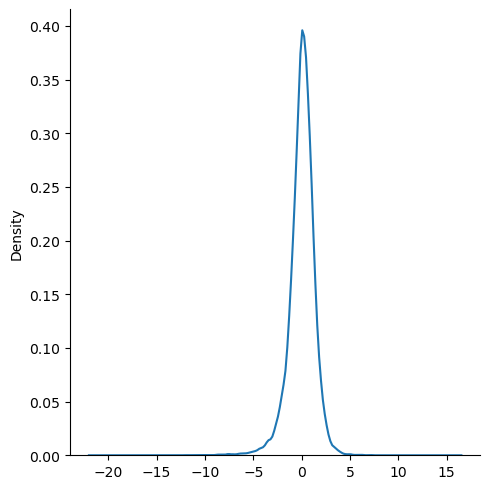

In [12]:
sns.displot(upperTriangle(dmso1_map),kind='kde')

#sns.displot(np.hstack(dmso1_map_geneneg.values),kind='kde',reg= True)
#plt.xlim(-10,10)

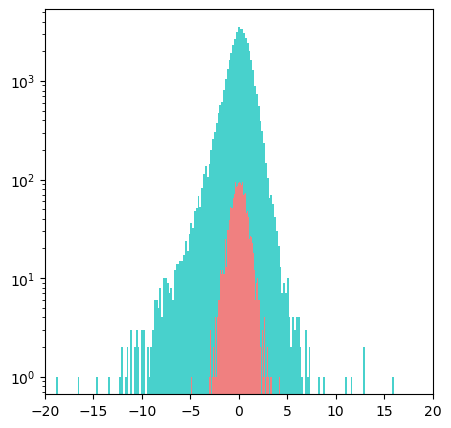

In [46]:
## Create interaction histograms for each map using the "interaction_hist" fucntion
interaction_hist(dmso1_map,dmso1_map_geneneg,dmso1_thresh,200)
#plt.savefig('/Users/benh/Desktop/for_figs/dmso1_distribution.png',dpi=300)

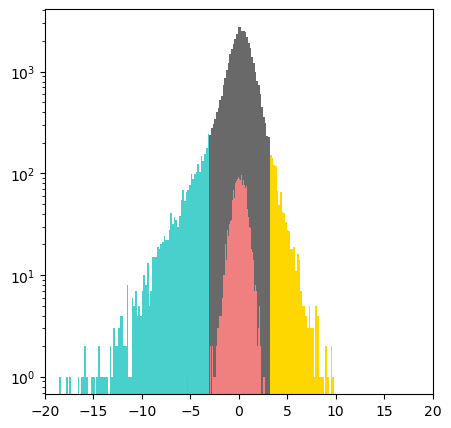

In [14]:
interaction_hist(atr_map,atr_map_geneneg,atr_thresh,200)
#plt.savefig('/Users/benh/Desktop/for_figs/atr_distribution.png',dpi=300)

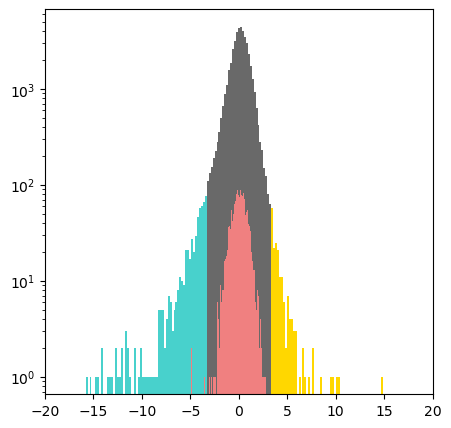

In [151]:
interaction_hist(dmso2_map,dmso2_map_geneneg,dmso2_thresh,200)
plt.savefig('/Users/benh/Desktop/for_figs/dmso2_distribution.png',dpi=300)

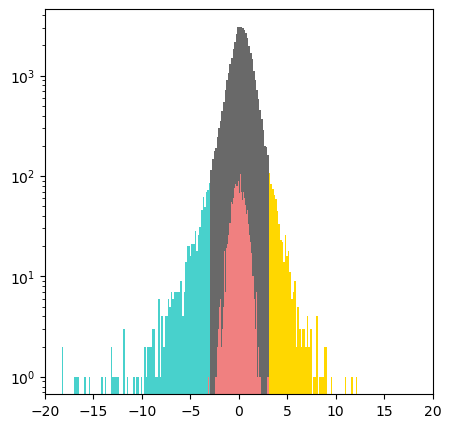

In [152]:
interaction_hist(etop_map,etop_map_geneneg,etop_thresh,200)
plt.savefig('/Users/benh/Desktop/for_figs/etop_distribution.png',dpi=300)

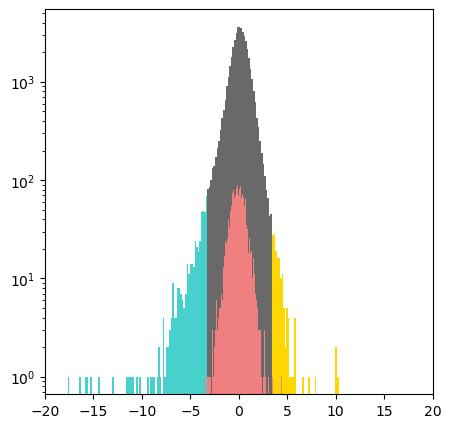

In [153]:
interaction_hist(keto_map,keto_map_geneneg,keto_thresh,200)
plt.savefig('/Users/benh/Desktop/for_figs/keto_distribution.png',dpi=300)

In [15]:
## Make difference matrices for both gene level and gene-ntc 

dmso_di_map = dmso1_map - dmso2_map
atr_di_map = atr_map - dmso1_map
etop_di_map = etop_map - dmso2_map
keto_di_map = keto_map - dmso2_map

dmso_di_geneneg = dmso1_map_geneneg - dmso2_map_geneneg
atr_di_geneneg = atr_map_geneneg - dmso1_map_geneneg
etop_di_geneneg = etop_map_geneneg - dmso2_map_geneneg
keto_di_geneneg = keto_map_geneneg - dmso2_map_geneneg

In [16]:
## Define di map thresholds for significance at five times the standard deviation of the gene-ntc distribution

dmso_di_thresh = np.hstack(dmso_di_geneneg.values).std()*5
atr_di_thresh = np.hstack(atr_di_geneneg.values).std()*5
etop_di_thresh = np.hstack(etop_di_geneneg.values).std()*5
keto_di_thresh = np.hstack(keto_di_geneneg.values).std()*5

In [17]:
print(dmso_di_thresh,atr_di_thresh,etop_di_thresh,keto_di_thresh)

5.586391215221745 5.235884266048073 4.683534588231303 4.610517297522741


In [18]:
## Use the "get_interactors" functions to define lists of threshold passed interactors in each dGI map

dmso_di_all,dmso_di_pos,dmso_di_neg = get_interactors(dmso_di_map,dmso_di_thresh)
atr_di_all,atr_di_pos,atr_di_neg = get_interactors(atr_di_map,atr_di_thresh)
etop_di_all,etop_di_pos,etop_di_neg = get_interactors(etop_di_map,etop_di_thresh)
keto_di_all,keto_di_pos,keto_di_neg = get_interactors(keto_di_map,keto_di_thresh)

In [19]:
print(len(dmso_di_all),len(atr_di_all),len(etop_di_all),len(keto_di_all))
print(len(dmso_di_pos),len(atr_di_pos),len(etop_di_pos),len(keto_di_pos))
print(len(dmso_di_neg),len(atr_di_neg),len(etop_di_neg),len(keto_di_neg))

22 665 285 166
8 200 199 124
14 465 86 42


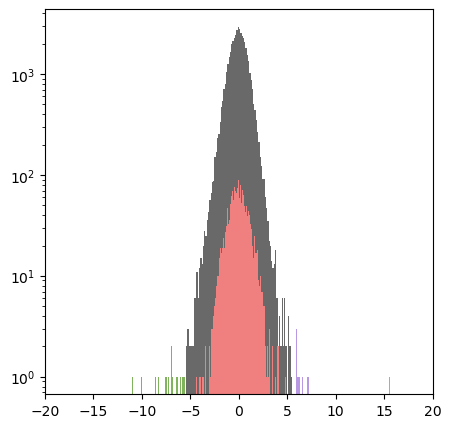

In [139]:
interaction_di_hist(dmso_di_map,dmso_di_geneneg,dmso_di_thresh,200)
plt.savefig('/Users/benh/Desktop/for_figs/dmso_di_distribution.png',dpi=300)

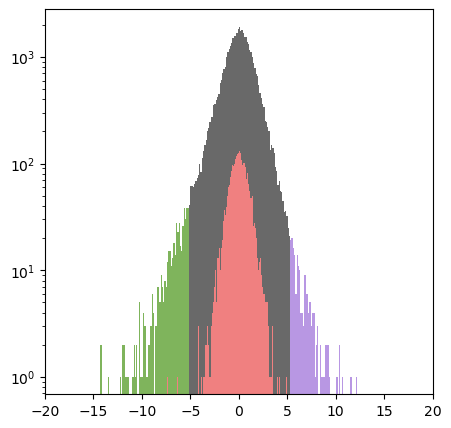

In [140]:
interaction_di_hist(atr_di_map,atr_di_geneneg,atr_di_thresh,200)
plt.savefig('/Users/benh/Desktop/for_figs/atr_di_distribution.png',dpi=300)

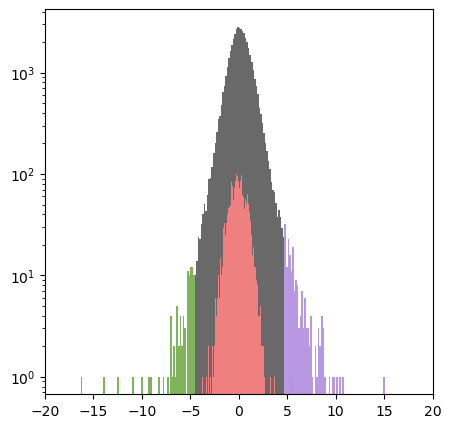

In [141]:
interaction_di_hist(etop_di_map,etop_di_geneneg,etop_di_thresh,200)
plt.savefig('/Users/benh/Desktop/for_figs/etop_di_distribution.png',dpi=300)

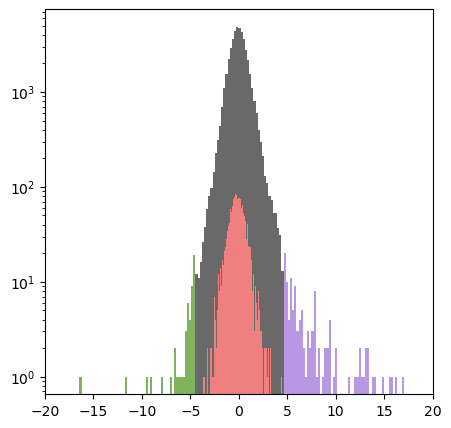

In [142]:
interaction_di_hist(keto_di_map,keto_di_geneneg,keto_di_thresh,200)
plt.savefig('/Users/benh/Desktop/for_figs/keto_di_distribution.png',dpi=300)

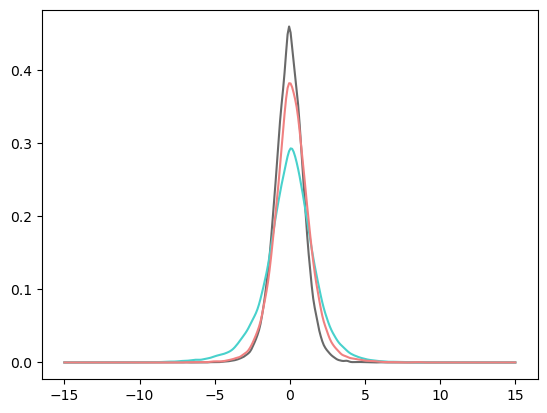

In [37]:
den1 = gaussian_kde(upperTriangle(dmso_di_map))
den2 = gaussian_kde(upperTriangle(atr_di_map))
den3 = gaussian_kde(upperTriangle(etop_di_map))
xs = np.linspace(-15,15,300)

plt.plot(xs,den1(xs),color = 'dimgray')
plt.plot(xs,den2(xs),color = 'mediumturquoise')
plt.plot(xs,den3(xs),color = 'lightcoral')

#plt.legend()
#plt.savefig('/Users/benh/Desktop/for_figs/dmso_di_kde.png',dpi=300)

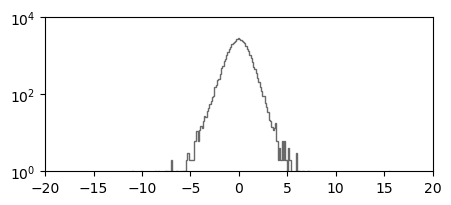

In [72]:
plt.figure(figsize=(5,2))
plt.hist(upperTriangle(dmso_di_map),bins=200,color = 'dimgray',log=True,histtype='step')
#plt.hist(upperTriangle(atr_di_map),bins=200,color = 'lightcoral',log=True,histtype='step')
#plt.hist(upperTriangle(etop_di_map),bins=200,color = 'mediumturquoise',log=True,histtype='step')
#plt.hist(upperTriangle(keto_di_map),bins=200,color = 'forestgreen',log=True,histtype='step')
plt.xlim(-20,20)
plt.ylim(1,10000)
plt.savefig('/Users/benh/Desktop/for_figs/dmso_di_kde.png',dpi=300)

In [79]:
di_index_list = []
dmso_di_list = []
atr_di_list = []
etop_di_list = []
keto_di_list = []
for i in range(len(dmso_di_map.index)):
    g1 = dmso_di_map.index[i]
    for j in range(i+1,len(dmso_di_map.index)):
        g2 = dmso_di_map.index[j]
        di_index_list.append(g1+':'+g2)
        dmso_di_list.append(dmso_di_map.iloc[i,j])
        atr_di_list.append(atr_di_map.iloc[i,j])
        etop_di_list.append(etop_di_map.iloc[i,j])
        keto_di_list.append(keto_di_map.iloc[i,j])

differential_matrix = pd.DataFrame(index=di_index_list)
differential_matrix['dmso'] = dmso_di_list
differential_matrix['atr'] = atr_di_list
differential_matrix['etop'] = etop_di_list
differential_matrix['keto'] = keto_di_list


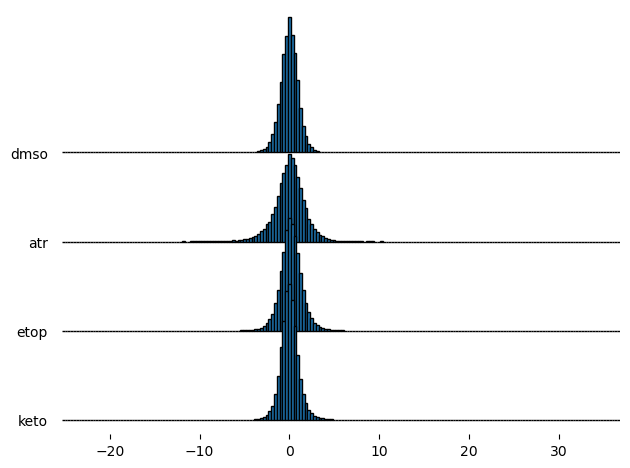

In [90]:
fig,ax =joypy.joyplot(differential_matrix,
             hist=True,
             bins=200,
              xlim = (-15,15)
             )
